In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from seaborn import load_dataset

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from joblib import Parallel, delayed

In [84]:
ROOT = Path().cwd()
PATHOGEN_DIR = ROOT.joinpath("../pathogens/norovirus").resolve()
ASSEMBLING = PATHOGEN_DIR / "genome"
STRAINS = PATHOGEN_DIR / "raw_data"
ALIGNMENT = STRAINS / "alignment"
ML = PATHOGEN_DIR / "ml"
RESULTS = ML / "results"
GERMAN_DIR = PATHOGEN_DIR.joinpath("test/german")

In [3]:
for i in ROOT, ASSEMBLING, STRAINS, ALIGNMENT, ML, RESULTS:
    i.mkdir(exist_ok=True)

In [4]:
ref = []
to_ref = ASSEMBLING / "norwalk_virus_GII.fasta"
for seq_record in SeqIO.parse(to_ref, "fasta"):
    ref.append(seq_record)
ref = ref[0]

In [5]:
ref

SeqRecord(seq=Seq('GTGAATGAAGATGGCGTCTAACGACGCTGCCACTGCGACCGCTGGCACAACCAG...TTT'), id='NC_044932.1', name='NC_044932.1', description='NC_044932.1 |Norovirus GII GII.NA2[PNA2], complete sequence', dbxrefs=[])

In [6]:
df = pd.DataFrame(columns=['fasta'], index=[0])
df.iloc[0,0] = str(ref.seq)

In [7]:
df

,fasta
0,GTGAATGAAGATGGCGTCTAACGACGCTGCCACTGCGACCGCTGGC...


In [8]:
mask_dna = {
    "A":[1, 0, 0 ,0, 0, 0],
    "G":[0, 1, 0 ,0, 0, 0],
    "C":[0, 0, 1 ,0, 0, 0],
    "T":[0, 0, 0 ,1, 0, 0],
    "N":[0, 0, 0 ,0, 1, 0],
    "-":[0, 0, 0 ,0, 0, 1]
}

In [9]:
reverse_terget_encode = {
        0 :"GI",
        1 :"GII",
        2 :"GIII",
        3 :"GIV",
        4 :"GV",
        5 :"GVI",
}

## По пунктам

In [57]:
def one_hot_encoding(seq:SeqRecord) -> np.array:
    dict_for_df = {"fasta":[]}
    new_df = pd.DataFrame(dict_for_df)
    new_df["fasta"] = [i for i in seq.seq]
    table = pd.get_dummies(new_df)
    if 'fasta_n' not in table.columns:
        table['fasta_n'] = np.zeros(len(table), dtype=int)
    if 'fasta_-' not in table.columns:
        table['fasta_-'] = np.zeros(len(table), dtype=int)
    table[['fasta_' + i.lower() for i in mask_dna.keys()]]
    return table.values.ravel()

In [11]:
def create_df(align:list, result:list, strain:str) -> pd.DataFrame:
    columns = []
    for pos in range(0,len(align[0])):
        for base in mask_dna.keys():
            columns.append(f"{pos}_{base}")
    columns = np.asarray(columns)
    index = [i.id for i in align[1:]]
    #df = pd.DataFrame(data=result, columns=columns, index=np.arange(0, len(result)))
    df = pd.DataFrame(data=result, columns=columns, index=index)
    if strain != 'False':
        df['class'] = np.repeat(target_encode[strain], len(df))
    return df

In [12]:
target_encode = {
        "GI"  : 0,
        "GII" : 1,
        "GIII": 2,
        "GIV" : 3,
        "GV"  : 4,
        "GVI" : 5
}

### mafft

In [13]:
for to_strain in STRAINS.glob("G*"):
    if to_strain.name == "norwalk_viruses.fasta":
        break
    to_align = STRAINS / "alignment" / f"{to_strain.name.split('.fasta')[0]}_align.fasta"
    if to_align.exists():
        print(f"Skipped: {to_strain}")
        break
    !mafft --reorder --localpair --thread 144 --maxambiguous 0.05 --addfragments {to_strain} --auto {to_ref}  > {to_align}

Skipped: /export/home/agletdinov/work/git_projects/pathogen_classifier/scripts/../pathogens/norovirus/raw_data/GI.fasta
maxunusual = 0.050000
nadd =  92
npair =  92
nseq =  93
nlen =  7815
use ktuples, size=6!
nadd = 92
ppenalty_ex = -10
nthread = 144
blosum 62 / kimura 200
sueff_global = 0.100000
norg = 1
njobc = 2
generating a scoring matrix for nucleotide (dist=200) ... done


Making a distance matrix ..

There are 8 ambiguous characters
    1 / 1 (thread    0)
done.

ffEP 91 / 92 (thread 91)                    fffffff

Combining ..
   done.                      

   done.                       

addsingle (nuc) Version 7.520
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
144 thread(s)


Strategy:
 FFT-NS-fragment (Not tested.)
 ?

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to

### table

In [58]:
df_for_strains = []
for to_strain in (STRAINS / "alignment").glob("G*"):
    if to_strain.name == "norwalk_viruses.fasta":
        continue
    print(to_strain.name)
    align = list()
    for seq_record in SeqIO.parse(to_strain, "fasta"):
        new_seq = ""
        for j, nucl in enumerate(seq_record.seq):
            nucl = nucl.lower()
            if nucl not in "agctn-":
                new_seq += "n"
            else:
                new_seq += nucl
        seq_record.seq = Seq(new_seq)
        align.append(seq_record)
    print(f"\talign length: {len(align)} ")
    #if to_strain.name in ['HBV_A_align.fasta','HBV_B_align.fasta','HBV_C_align.fasta','HBV_D_align.fasta']:
    #    align = align[:701]
    for i, seq_record in enumerate(align):
        seq_list = [i for i in seq_record.seq]
        if i == 0:
            res = sorted([i for i in range(len(seq_record.seq)) if seq_record.seq.startswith('-', i)], reverse=True)  
        for pos in res:
            del seq_list[pos]
        seq_record.seq = "".join(seq_list)
    
    #result = [one_hot_encoding(seq=i) for i in align[1:]]
    result = [one_hot_encoding(seq=i) for i in align[1:]]
    df = create_df(align=align, result=result, strain=to_strain.name.split("_")[0]).sample(frac=1, random_state=10)
    df_for_strains.append(df)

GI_align.fasta
	align length: 93 
GII_align.fasta
	align length: 1357 
GIII_align.fasta
	align length: 9 
GIV_align.fasta
	align length: 11 
GV_align.fasta
	align length: 54 
GVI_align.fasta
	align length: 3 


In [64]:
[i.shape for i in df_for_strains]

[(92, 45151), (1356, 45151), (8, 45151), (10, 45151), (53, 45151), (2, 45151)]

In [65]:
df_for_strains[0]

,0_A,0_G,0_C,0_T,0_N,0_-,1_A,1_G,1_C,1_T,...,7523_T,7523_N,7523_-,7524_A,7524_G,7524_C,7524_T,7524_N,7524_-,class
MG049693.1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
MH218730.1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
NC_044854.1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
KY934262.1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
KF039735.1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KF429789.1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
KF429783.1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
MT357995.1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
KF039731.1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [66]:
batches = pd.concat(df_for_strains)

In [67]:
#subbatches = batches.sample(frac=0.2, random_state=10)
subbatches = batches

In [68]:
subbatches

,0_A,0_G,0_C,0_T,0_N,0_-,1_A,1_G,1_C,1_T,...,7523_T,7523_N,7523_-,7524_A,7524_G,7524_C,7524_T,7524_N,7524_-,class
MG049693.1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
MH218730.1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
NC_044854.1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
KY934262.1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
KF039735.1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EU004671.1,0,0,0,0,0,1,0,0,0,1,...,0,0,1,1,0,0,0,0,0,4
JF320649.1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,4
EU004665.1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,4
MW662289.1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,5


### ml

In [69]:
len(subbatches.columns)

45151

In [70]:
FEATURES = list(subbatches.columns)
FEATURES.remove('class')

In [71]:
len(FEATURES)

45150

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(subbatches[FEATURES], subbatches["class"], train_size=0.7, random_state=10)

In [73]:
GRID = {

    ("Gradient Boosting", GradientBoostingClassifier()): {
         'loss': ['log_loss'],
         'learning_rate': [0.01, 0.1, 0.15],
         'subsample': [0.5],
         'n_estimators': [100, 200],
         'max_depth': [6, 7, 8],
         'max_features': [None],#None, 'sqrt'],
         'random_state': [27]
         # TODO: grid for min_samples_leaf
     },
    ("Decision Tree", DecisionTreeClassifier()): {
        "criterion": ["entropy"],
        "max_depth": [7, 8, 9],
        "class_weight": [None],
        'random_state': [27]
        # TODO: add max_depth None and max_samples_leaf
    },
}

GRID = {

    ("Gradient Boosting", GradientBoostingClassifier()): {
         'loss': ['log_loss'],
         'learning_rate': [0.01, 0.1, 0.15],
         'subsample': [0.5],
         'n_estimators': [100, 200],
         'max_depth': [6, 7, 8],
         'max_features': [None],#None, 'sqrt'],
         'random_state': [27]
         # TODO: grid for min_samples_leaf
     },

    ("Random Forest", RandomForestClassifier()): {
         'criterion': ["entropy"],
         'max_features': [None],
         # TODO: better grid for min_samples_leaf
         'min_samples_leaf': [0.001, 0.005, 0.01, 0.5],
         'n_estimators': [50, 100],
         'class_weight': ['balanced_subsample', 'balanced'],
         'random_state': [27],
         'n_jobs': [-1]
    },
    ("Extra Tree", ExtraTreesClassifier()): {
        "criterion": ["gini"],
        "max_depth": [7, 8, 9],
        "class_weight": [None],
        'random_state': [27]
    },
    ("Decision Tree", DecisionTreeClassifier()): {
        "criterion": ["entropy"],
        "max_depth": [7, 8, 9],
        "class_weight": [None],
        'random_state': [27]
        # TODO: add max_depth None and max_samples_leaf
    },

    # ("K-Neighbors", KNeighborsClassifier()): {
    #     # TODO: better parametrization for n_neighbors
    #     'n_neighbors': [1, 2, 3, 4, 5, 7],
    #     'metric': ['l1', 'l2', 'cosine'],
    #     "weights": ["uniform"]#, "distance"]
    # },

    # ("Logistic Regression", LogisticRegression()): {
    #     'penalty': ['l1', 'l2', 'elasticnet'],
    #     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100],
    #     'class_weight': [None, 'balanced'],
    #     'solver': ['saga'],
    #     'random_state': [27]
    # },

    # ("SVC", SVC()): {
    #     'C': [0.1, 1, 10, 100, 1000], 
    #     'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    #     'kernel': ['rbf']
    # },
}

In [74]:
def job(key, model, grid):
    saveto = RESULTS / f"{key}_v2.pkl"
    if saveto.exists():
        return

    print(f"{key} grid search")
    grid = GridSearchCV(
        model, grid, scoring='f1_macro', cv=KFold(n_splits=3, shuffle=True, random_state=27), n_jobs=-1,
        verbose=100, refit=True
    ).fit(X_train, Y_train)

    print(f"\t{key} grid finished")

    results = {
        "grid": grid
    }

    with open(saveto, 'wb') as stream:
        pickle.dump(results, stream)


_ = Parallel(n_jobs=-1, backend='threading')(
    delayed(job)(key, model, grid)
    for (key, model), grid in GRID.items()
)

Decision Tree grid search
Gradient Boosting grid search
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/3] START class_weight=None, criterion=entropy, max_depth=7, random_state=27
[CV 2/3; 1/3] START class_weight=None, criterion=entropy, max_depth=7, random_state=27
[CV 3/3; 1/3] START class_weight=None, criterion=entropy, max_depth=7, random_state=27
[CV 1/3; 2/3] START class_weight=None, criterion=entropy, max_depth=8, random_state=27
[CV 2/3; 2/3] START class_weight=None, criterion=entropy, max_depth=8, random_state=27
[CV 3/3; 2/3] START class_weight=None, criterion=entropy, max_depth=8, random_state=27
[CV 1/3; 3/3] START class_weight=None, criterion=entropy, max_depth=9, random_state=27
[CV 2/3; 3/3] START class_weight=None, criterion=entropy, max_depth=9, random_state=27
[CV 3/3; 3/3] START class_weight=None, criterion=entropy, max_depth=9, random_state=27
[CV 1/3; 1/18] START learning_rate=0.01, 

IOStream.flush timed out
IOStream.flush timed out


[CV 1/3; 14/18] START learning_rate=0.15, loss=log_loss, max_depth=6, max_features=None, n_estimators=200, random_state=27, subsample=0.5
[CV 2/3; 14/18] START learning_rate=0.15, loss=log_loss, max_depth=6, max_features=None, n_estimators=200, random_state=27, subsample=0.5
[CV 3/3; 14/18] START learning_rate=0.15, loss=log_loss, max_depth=6, max_features=None, n_estimators=200, random_state=27, subsample=0.5
[CV 1/3; 15/18] START learning_rate=0.15, loss=log_loss, max_depth=7, max_features=None, n_estimators=100, random_state=27, subsample=0.5
[CV 2/3; 15/18] START learning_rate=0.15, loss=log_loss, max_depth=7, max_features=None, n_estimators=100, random_state=27, subsample=0.5
[CV 3/3; 15/18] START learning_rate=0.15, loss=log_loss, max_depth=7, max_features=None, n_estimators=100, random_state=27, subsample=0.5
[CV 1/3; 16/18] START learning_rate=0.15, loss=log_loss, max_depth=7, max_features=None, n_estimators=200, random_state=27, subsample=0.5
[CV 2/3; 16/18] START learning_rat

IOStream.flush timed out
IOStream.flush timed out


[CV 2/3; 2/3] END class_weight=None, criterion=entropy, max_depth=8, random_state=27;, score=0.977 total time= 5.6min


IOStream.flush timed out


[CV 1/3; 3/3] END class_weight=None, criterion=entropy, max_depth=9, random_state=27;, score=0.777 total time= 7.4min
[CV 2/3; 1/3] END class_weight=None, criterion=entropy, max_depth=7, random_state=27;, score=0.977 total time= 8.5min
[CV 3/3; 1/3] END class_weight=None, criterion=entropy, max_depth=7, random_state=27;, score=0.960 total time= 8.9min
[CV 1/3; 2/3] END class_weight=None, criterion=entropy, max_depth=8, random_state=27;, score=0.777 total time= 9.1min


IOStream.flush timed out
IOStream.flush timed out


[CV 3/3; 2/3] END class_weight=None, criterion=entropy, max_depth=8, random_state=27;, score=0.960 total time=10.2min
[CV 2/3; 3/3] END class_weight=None, criterion=entropy, max_depth=9, random_state=27;, score=0.977 total time=10.2min
[CV 1/3; 1/3] END class_weight=None, criterion=entropy, max_depth=7, random_state=27;, score=0.777 total time=10.7min
[CV 3/3; 3/3] END class_weight=None, criterion=entropy, max_depth=9, random_state=27;, score=0.960 total time=10.9min
	Decision Tree grid finished
[CV 1/3; 13/18] END learning_rate=0.15, loss=log_loss, max_depth=6, max_features=None, n_estimators=100, random_state=27, subsample=0.5;, score=0.833 total time=11.4min
[CV 2/3; 13/18] END learning_rate=0.15, loss=log_loss, max_depth=6, max_features=None, n_estimators=100, random_state=27, subsample=0.5;, score=0.777 total time=11.3min
[CV 1/3; 14/18] END learning_rate=0.15, loss=log_loss, max_depth=6, max_features=None, n_estimators=200, random_state=27, subsample=0.5;, score=0.833 total time=

In [75]:
SUMMARY = {"models": {}}
for path in RESULTS.iterdir():
    if "_v2" in path.name:
        if '.pkl' not in path.name or '_1.pkl' in path.name:
            continue
        with open(path, 'rb') as stream:
            data = pickle.load(stream)

        if path.name == "sample.pkl":
            SUMMARY.update(data)
        else:
            name = path.name.split('.')[0]
            SUMMARY['models'][name] = data

In [76]:
SUMMARY['models'].keys()

dict_keys(['Decision Tree_v2', 'Gradient Boosting_v2'])

In [148]:
def confusion_matrix_draw(Y_pred, Y_test, name):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(Y_test, Y_pred),
        display_labels=target_encode.keys(),
    )
    plt.title(name)
    cmp.plot(ax=ax)
    
    plt.show();

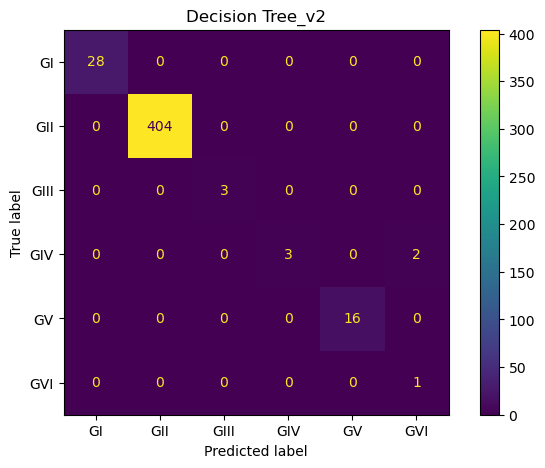

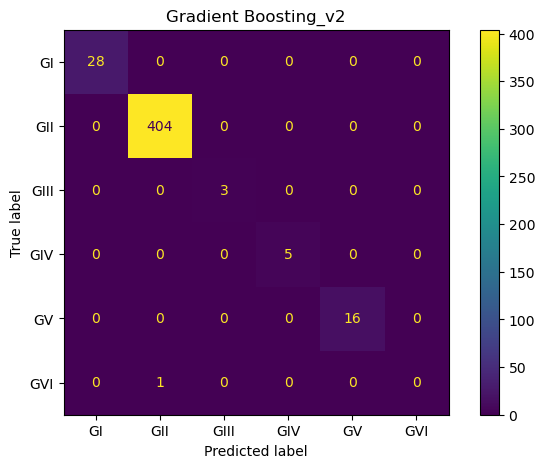

In [186]:
for name, model in SUMMARY['models'].items():
    m = model['grid'].best_estimator_
    Y_pred = m.predict(X_test)
    confusion_matrix_draw(Y_pred, Y_test, name)

In [120]:
m = SUMMARY['models']['Decision Tree_v2']["grid"].best_estimator_
Y_pred = m.predict(X_test)

In [121]:
Y_pred

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 4, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [126]:
k = 0
for i,j in zip(Y_test, Y_pred):
    k += 1
    if i !=j:
        print(k)
        print(i,j)

100
3 1


In [130]:
X_test.iloc[100]

0_A       1
0_G       0
0_C       0
0_T       0
0_N       0
         ..
7524_G    0
7524_C    0
7524_T    0
7524_N    0
7524_-    0
Name: 789, Length: 45150, dtype: object

In [93]:
m1 = SUMMARY['models']['Random Forest']["grid"].best_estimator_

In [94]:
feature_importances = {}
for name, score in zip(m1.feature_names_in_, m1.feature_importances_):
    feature_importances[name] = score

In [95]:
sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

[('4568_C', 0.014267676034665142),
 ('4568_T', 0.013109175070825686),
 ('3665_G', 0.012544969802371566),
 ('1628_T', 0.012544969802371499),
 ('2039_C', 0.0100860194338746),
 ('3541_T', 0.0100860194338746),
 ('788_C', 0.010086019433874596),
 ('4208_G', 0.008363313201581032),
 ('1825_C', 0.00836331320158103),
 ('3629_T', 0.008363313201581029),
 ('4483_T', 0.008363313201581022),
 ('1886_T', 0.008363313201581016),
 ('5549_T', 0.008363313201581016),
 ('1429_T', 0.008363313201581013),
 ('3371_C', 0.008363313201581008),
 ('3100_T', 0.006554587535412883),
 ('1658_T', 0.0065545875354128535),
 ('3883_C', 0.006554587535412841),
 ('1591_T', 0.0065545875354128345),
 ('2678_T', 0.006554587535412824),
 ('4567_G', 0.005904362833084142),
 ('3946_T', 0.005904362833084114),
 ('1613_C', 0.005904362833084099),
 ('4871_C', 0.005904362833084099),
 ('4940_C', 0.005904362833084099),
 ('4489_G', 0.00590436283308409),
 ('6664_T', 0.005904362833084088),
 ('3499_T', 0.0059043628330840685),
 ('1490_C', 0.0049999999

<Axes: >

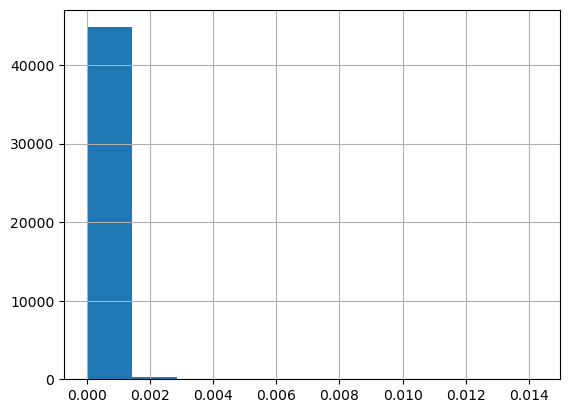

In [96]:
pd.DataFrame({"feature_importances":m1.feature_importances_}).feature_importances.hist()

In [97]:
pd.DataFrame({"feature_importances":m1.feature_importances_}).feature_importances.sum()

1.0000000000000002

<Axes: >

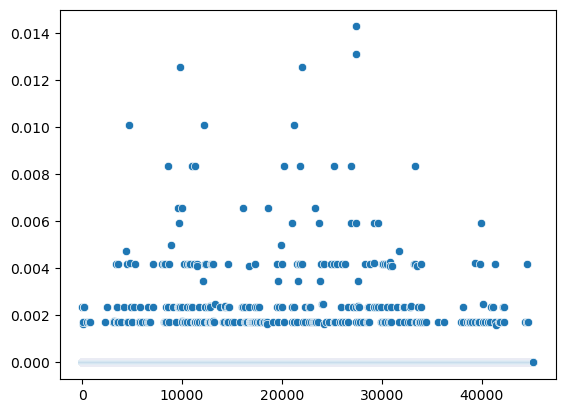

In [98]:
sns.scatterplot(x=np.arange(0, len(m1.feature_names_in_)), y=m1.feature_importances_)

In [100]:
SUMMARY['models']['Random Forest']['grid'].best_estimator_.feature_importances_.max()

0.014267676034665142

In [101]:
target_encode.keys()

dict_keys(['GI', 'GII', 'GIII', 'GIV', 'GV'])

sample = 'Y_test'

Y_true = SUMMARY[sample].reset_index()

experiments = Y_true['experiment']
uniqexp = Y_true['experiment'].unique()

Y_true = Y_true['class']

records = []
for model, data in SUMMARY['models'].items():
    Y_score = data[sample][:, 1]
    Y_pred = data[sample].argmax(axis=-1)
    modelres = []
    
    for exp in uniqexp:
        mask = (experiments == exp)
        # print(exp, mask.sum())

        modelres.append({
            "Experiment": exp,
            "Model": model,
            "F1-score": f1_score(Y_true[mask], Y_pred[mask]),
            "ROC AUC": roc_auc_score(Y_true[mask], Y_score[mask]),
            "PR AUC": average_precision_score(Y_true[mask], Y_score[mask]),
            "Precision": precision_score(Y_true[mask], Y_pred[mask]),
            "Recall": recall_score(Y_true[mask], Y_pred[mask]),
            "Parameters": data['grid'].best_params_,
        })
    
    avg = {"Experiment": "Macro average", "Model": model, "Parameters": data['grid'].best_params_}
    for metric in "F1-score", "ROC AUC", "PR AUC",  "Precision", "Recall":
        avg[metric] = np.mean([exp[metric] for exp in modelres])
    modelres.append(avg)

    modelres.append({
        "Experiment": "Micro average",
        "Model": model,
        "F1-score": f1_score(Y_true, Y_pred),
        "ROC AUC": roc_auc_score(Y_true, Y_score),
        "PR AUC": average_precision_score(Y_true, Y_score),
        "Precision": precision_score(Y_true, Y_pred),
        "Recall": recall_score(Y_true, Y_pred),
        "Parameters": data['grid'].best_params_,
    })

    records.extend(modelres)

records = pd.DataFrame(records).set_index(['Experiment', 'Model'])
for k in "F1-score", "ROC AUC", "PR AUC":
    records[k] = records[k].round(3)

### test

In [91]:
ids_test_df = pd.read_csv(GERMAN_DIR / "ids", header=None, names=["ncbi_id"])
ids_test_df.head()

,ncbi_id
0,MW661246.1
1,LC769711.1
2,LC769686.1
3,KY934262.1
4,MH218723.1


In [93]:
len(ids_test_df)

890

In [136]:
german_seq = []
german_seq_clade = []
to_seq = GERMAN_DIR / "all.fasta"
for seq_record in SeqIO.parse(to_seq, "fasta"):
    if seq_record.id.split("|")[0] in list(ids_test_df["ncbi_id"]):
        german_seq.append(seq_record)
        german_seq_clade.append(seq_record.id)

In [189]:
german_seq_clade_series = pd.Series([int(i.split("|")[1])-1 for i in german_seq_clade], index=[i.split("|")[0] for i in german_seq_clade], name="class")

In [190]:
len(german_seq)

889

In [111]:
SeqIO.write(german_seq, GERMAN_DIR.joinpath("only_seq_in_ids.fasta"), "fasta")

889

In [116]:
to_strain = GERMAN_DIR / f"only_seq_in_ids.fasta"
to_align = GERMAN_DIR / "alignment" / f"only_seq_in_ids_align.fasta"
!mafft --reorder --localpair --thread 144 --maxambiguous 0.5 --addfragments {to_strain} --auto {to_ref}  > {to_align}

maxunusual = 0.500000
nadd =  889
npair =  889
nseq =  890
nlen =  7967
use ktuples, size=6!
nadd = 889
ppenalty_ex = -10
nthread = 144
blosum 62 / kimura 200
sueff_global = 0.100000
norg = 1
njobc = 2
generating a scoring matrix for nucleotide (dist=200) ... done


Making a distance matrix ..

There are 1412 ambiguous characters
    1 / 1 (thread    0)
done.

fTEP 499 / 889 (thread 142)                    ffffff
STEP 500 / 889 (thread 120)                    
ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 600 / 889 (thread 35)                    
fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 700 / 889 (thread 78)                    
fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 800 / 889 (thread 1)                    
fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff

C

In [174]:
df_for_test = []
for to_strain in (GERMAN_DIR / "alignment").glob("*.fasta"):
    if ".ipynb_checkpoint" in to_strain.name:
        continue
    print(to_strain.name)
    align = list()
    for seq_record in SeqIO.parse(to_strain, "fasta"):
        new_seq = ""
        for j, nucl in enumerate(seq_record.seq):
            nucl = nucl.lower()
            if nucl not in "agctn-":
                new_seq += "n"
            else:
                new_seq += nucl
        seq_record.seq = Seq(new_seq)
        align.append(seq_record)
    print(f"\talign length: {len(align)} ")
    for i, seq_record in enumerate(align):
        seq_list = [i for i in seq_record.seq]
        if i == 0:
            res = sorted([i for i in range(len(seq_record.seq)) if seq_record.seq.startswith('-', i)], reverse=True)  
        for pos in res:
            del seq_list[pos]
        seq_record.seq = "".join(seq_list)
    
    result = [one_hot_encoding(seq=i) for i in align[1:]]
    df = create_df(align=align, result=result, strain="False").sample(frac=1, random_state=10)
    df_for_test.append(df)

only_seq_in_ids_align.fasta
	align length: 890 


In [175]:
df_for_test = pd.concat(df_for_test)

In [176]:
df_for_test = df_for_test.loc[german_seq_clade]

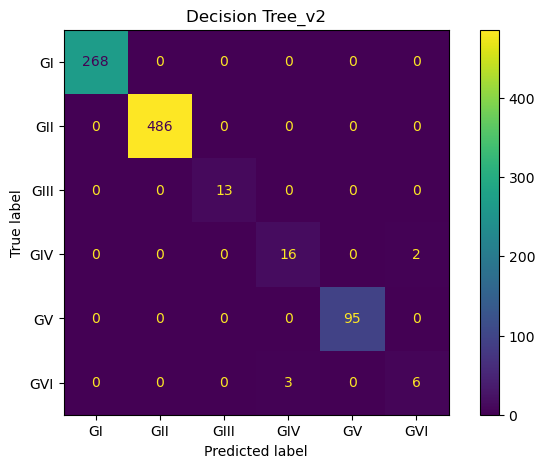

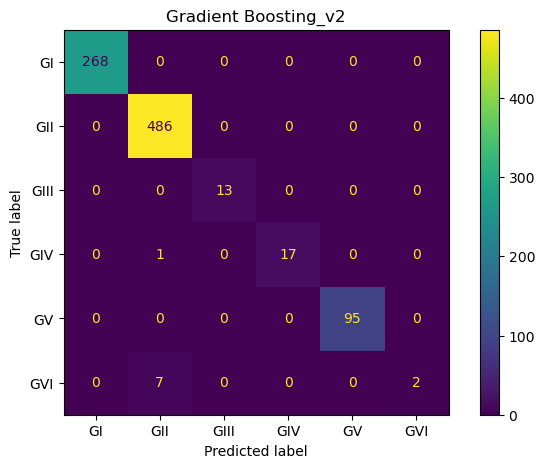

In [191]:
for name, model in SUMMARY['models'].items():
    m = model['grid'].best_estimator_
    Y_pred = m.predict(df_for_test[FEATURES])
    confusion_matrix_draw(Y_pred, german_seq_clade_series, name)

In [198]:
DT = SUMMARY['models']['Decision Tree_v2']['grid'].best_estimator_

In [199]:
GB = SUMMARY['models']["Gradient Boosting_v2"]['grid'].best_estimator_

In [210]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Обученные модели
DT = SUMMARY['models']['Decision Tree_v2']['grid'].best_estimator_
GB = SUMMARY['models']["Gradient Boosting_v2"]['grid'].best_estimator_

# Определение мета-классификатора
lr = LogisticRegression()

# Стекинг моделей
clf_stack = StackingClassifier(
    estimators=[('dt', DT), ('gb', GB)],  # добавляем имена моделей
    final_estimator=lr,
    n_jobs=-1
)

In [211]:
clf_stack.fit(X_train, Y_train)

IOStream.flush timed out
/export/home/agletdinov/mambaforge/envs/reat/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/export/home/agletdinov/mambaforge/envs/reat/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1098: RuntimeWarning: Number of classes in training fold (5) does not match total number of classes (6). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/export/home/agletdinov/mambaforge/envs/reat/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/export/home/agletdinov/mambaforge/envs/reat/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1098: RuntimeWarning: Number of classes in

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       random_state=27)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_depth=6,
                                                           random_state=27,
                                                           subsample=0.5))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

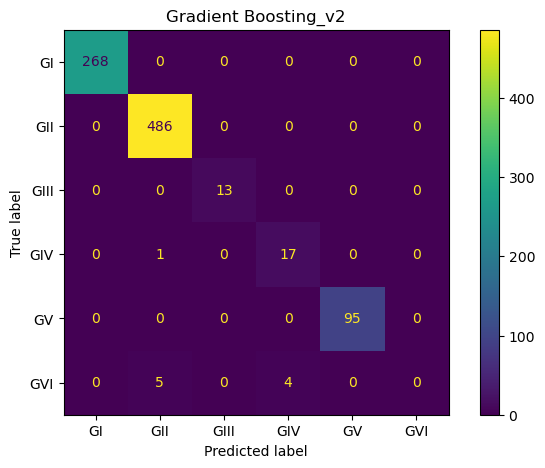

In [212]:
m = clf_stack
Y_pred = m.predict(df_for_test[FEATURES])
confusion_matrix_draw(Y_pred, german_seq_clade_series, name)

In [188]:
Y_test

KC175323.1    1
LC769707.1    1
KU561248.1    1
KF429761.1    0
MH218635.1    1
             ..
KC894731.1    3
AB541235.1    1
AB541353.1    1
EU004664.1    4
EF187497.2    1
Name: class, Length: 457, dtype: int64

In [182]:
german_seq_clade_series

LC769711.1    1
LC769686.1    1
KY934262.1    1
MH218723.1    1
MT372462.1    1
             ..
MK067293.1    6
MN908340.1    6
PQ182552.1    6
MW945229.1    6
MK067295.1    6
Name: class, Length: 889, dtype: object

In [156]:
m1 = SUMMARY['models']['Decision Tree_v2']['grid'].best_estimator_
Y_pred = m1.predict(df_for_test[FEATURES])

In [119]:
target_encode

{'GI': 0, 'GII': 1, 'GIII': 2, 'GIV': 3, 'GV': 4}

In [163]:
df_for_test

,0_A,0_G,0_C,0_T,0_N,0_-,1_A,1_G,1_C,1_T,...,7523_C,7523_T,7523_N,7523_-,7524_A,7524_G,7524_C,7524_T,7524_N,7524_-
MG572719.1|2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
MW305518.1|2,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
MW305625.1|2,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
MT008458.1|1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
OP205581.1|2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KC463910.1|2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
KJ710245.2|2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
MW854326.1|2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
LC122710.1|1,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [122]:
SUMMARY['models'].keys()

dict_keys(['Decision Tree_v2', 'Gradient Boosting_v2'])

In [147]:
german_seq_clade_series

LC769711.1    1
LC769686.1    1
KY934262.1    1
MH218723.1    1
MT372462.1    1
             ..
MK067293.1    6
MN908340.1    6
PQ182552.1    6
MW945229.1    6
MK067295.1    6
Name: class, Length: 889, dtype: object

In [890]:
name_cont = list()
strain_cont = list()
for to_strain, strain in zip((ML / "test" / "alignment").glob("crie*"), Y_pred):
    #print(to_strain.name.split(".")[0], reverse_terget_encode[strain])
    name_cont.append(to_strain.name.split(".")[0])
    strain_cont.append(reverse_terget_encode[strain])

In [891]:
res_df = pd.DataFrame(columns=['crie', 'strain'])
res_df['crie'] = name_cont
res_df['strain'] = strain_cont
res_df.sort_values(by='crie', inplace=True)
res_df.to_csv('res_matvei.csv', index=False)

In [896]:
res_df=res_df.set_index('crie')

In [898]:
german = pd.read_excel("hepat.xlsx").set_index("id последовательности")
final=german.join(res_df)

In [905]:
mask = np.where(final['1'] == final['strain'], 1, 0)
mask

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [842]:
SUMMARY['models']['Gradient Boosting']['grid'].best_estimator_

GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=27,
                           subsample=0.5)

In [843]:
Y_pred

array([0, 0, 0, 0, 0, 0, 0])

In [781]:
target_encode

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'RF': 8}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)

In [301]:
from collections import defaultdict

nucl_count = defaultdict(int)
intersect = [set(i.seq) for i in align_a]
for i in intersect:
    for j in i:
        nucl_count[j] += 1

In [534]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=1000, n_features=5, n_informative=4, n_redundant=1, n_classes=4
)

In [302]:
nucl_count

defaultdict(int,
            {'t': 1067, '-': 1067, 'c': 1067, 'a': 1067, 'n': 249, 'g': 1067})

In [266]:
[len(i) for i in align_a]

[3183,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3203,
 3212,
 3221,
 3221,
 3221,
 3197,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3188,
 3221,
 3221,
 3215,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3200,
 3221,
 3221,
 3221,
 3221,
 3203,
 3221,
 3221,
 3221,
 3221,
 3221,
 3197,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3197,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3203,
 3221,
 3221,
 3218,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3218,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3209,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,
 3221,